## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import seaborn  as sns

**Result**: the LSTM is pretty bad when trained on individual financial time series, instead, we'll use the first 100 time series to predict 1, hence the model we'll include the correlations between the different time series.

## Import data

In [3]:
df = pd.read_csv('data/nasdaq_100_prices_with_delay.csv')

df['Date'] = pd.to_datetime(df['Date'])
companies = df['Company'].unique().tolist()
dates = df['Date'].drop_duplicates().values

/var/folders/pg/mh4np6_d0qs9cxq5clx1wbbw0000gn/T/ipykernel_1052/2238298081.py:1: DtypeWarning: Columns (1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,25

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190697 entries, 0 to 190696
Columns: 507 entries, Date to Volume.100
dtypes: datetime64[ns](1), object(506)
memory usage: 737.6+ MB


## Data Preprocessing

In [96]:
from tqdm import tqdm

data = []
features = 200

for company in tqdm(companies[:features]):
    company_data = df[df['Company'] == company]['High'].values
    company_data = (company_data[1:] - company_data[:-1]) / company_data[:-1]
    data.append(company_data)

# Time series must be same duration, else zero-pad first
data = np.array(data) * 100 # Shape : (features, timesteps)

100%|██████████| 200/200 [00:02<00:00, 68.67it/s]


Here, one feature corresponds to a time serie.

In [97]:
data.shape

(200, 1257)

### Plotting retruns

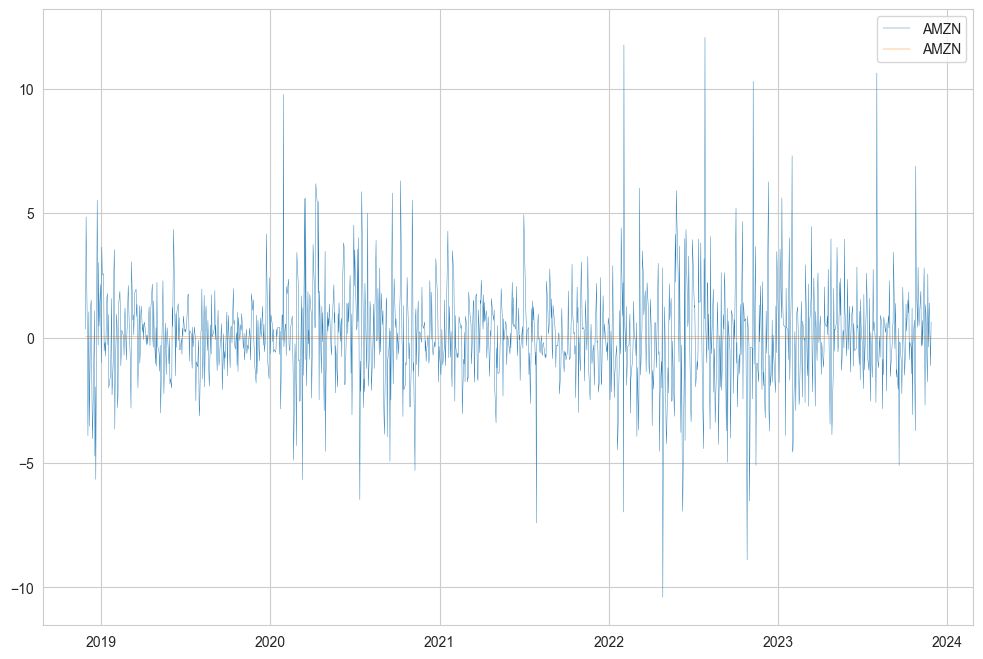

In [98]:
plt.figure(figsize=(12, 8))
sns.set_style('whitegrid')
for k in range(3,4):
    plt.plot(dates[:-1], data[k], label=companies[k], linewidth=0.3)
    plt.plot(dates[:-1], np.ones(len(data[k])) * np.mean(data[k]), label=companies[k], linewidth=0.3)
plt.legend()
plt.show()

## Encode returns

In [99]:
import numpy as np

def encode_value(value, K):
    """Encode a single value based on the specified ranges."""
    if value < -K:
        return f"D{K-1}+"
    for i in range(1, K + 1):
        if -i <= value < -(i - 1):
            return f"D{i-1}"
    if 0 <= value < 1:
        return "U0"
    for i in range(2, K + 1):
        if i - 1 <= value < i:
            return f"U{i-1}"
    if value >= K:
        return f"U{K-1}+"
    return None  # This case should not occur

def encode_returns(data, K):
    """
    Encodes the numerical returns into discrete string levels D1, D2,...DK,DK+ and U1, U2, ...UK, UK+.

    Parameters:
        data (np.ndarray): The array of shape (features, timesteps) containing return values.
        K (int): The number of levels for encoding.

    Returns:
        np.ndarray: Encoded array with the same shape as data, containing the encoded strings.
    """

    # Flatten the data for processing
    flat_data = data.flatten()
    
    # Encode each value using the explicit logic
    encoded_flat_data = np.array([encode_value(value, K) for value in flat_data])

    # Reshape back to the original data shape
    encoded_data = encoded_flat_data.reshape(data.shape)
    
    return encoded_data

# Example usage
K = 3  # Number of levels for encoding
encoded_data = encode_returns(data, K)

In [100]:
for k in range(len(data[0])):
    print(f"Value: {data[0][k]}")
    print(f"Encoded Label: {encoded_data[0][k]}")

Value: -1.3512026368930876
Encoded Label: D1
Value: 2.556434973637765
Encoded Label: U2
Value: -1.3788278504165141
Encoded Label: D1
Value: -4.172375209242731
Encoded Label: D2+
Value: -0.1659167496643945
Encoded Label: D0
Value: -2.5216437321949465
Encoded Label: D2
Value: 0.9994612812052913
Encoded Label: U0
Value: 0.07566634726742323
Encoded Label: U0
Value: 0.3780843022428637
Encoded Label: U0
Value: -2.0223721681362967
Encoded Label: D2
Value: -0.4317081627278128
Encoded Label: D0
Value: -0.4871223867114641
Encoded Label: D0
Value: -0.04774730167607242
Encoded Label: D0
Value: -3.1890134044004275
Encoded Label: D2+
Value: -2.436609805837443
Encoded Label: D2
Value: -4.179291295516394
Encoded Label: D2+
Value: 3.7479097059301476
Encoded Label: U2+
Value: -0.29251423400569787
Encoded Label: D0
Value: 1.1162819883528896
Encoded Label: U1
Value: 0.5298596222166295
Encoded Label: U0
Value: -0.3200159152008891
Encoded Label: D0
Value: -8.26567440441887
Encoded Label: D2+
Value: 1.942097

In [101]:
print(f'raw_data : {encoded_data}')
print(f'raw_data shape: {encoded_data.shape}')

raw_data : [['D1' 'U2' 'D1' ... 'D0' 'U0' 'U0']
 ['D0' 'U2' 'D0' ... 'U0' 'U0' 'U0']
 ['U0' 'U2' 'D1' ... 'U0' 'D0' 'U0']
 ...
 ['U1' 'U1' 'D1' ... 'U0' 'U0' 'D0']
 ['D0' 'U2' 'D0' ... 'U0' 'U0' 'D0']
 ['D0' 'U0' 'U0' ... 'U0' 'U0' 'U0']]
raw_data shape: (200, 1257)


## Single valued time series prediction

In [127]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

# Step 1: Encode the categorical data
raw_data = np.array(encoded_data)  # Assuming raw_data is already loaded as a NumPy array
le = LabelEncoder()
flattened_data = raw_data.flatten()  # Flatten the 2D data for encoding
le_encoded_data = le.fit_transform(flattened_data).reshape(raw_data.shape)

# Step 2: Prepare the dataset
def create_dataset(data, look_back=10):
    X, y = [], []
    for series in data:
        for i in range(len(series) - look_back):
            X.append(series[i:i + look_back])
            y.append(series[i + look_back])
    return np.array(X), np.array(y)

look_back = 100  # Number of past values to consider
X, y = create_dataset(le_encoded_data, look_back=look_back)

# Reshape X for LSTM input (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Step 3: Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [128]:
X.shape

(231400, 100, 1)

In [ ]:
# Step 4: Build the LSTM model
model = Sequential([
    LSTM(256, input_shape=(look_back, 1)),
    Dense(len(le.classes_), activation='softmax')  # Output layer for classification
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 5: Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Step 6: Predictions
predicted_classes = model.predict(X_val[:5])  # Predict for the first 5 validation samples
predicted_labels = le.inverse_transform(np.argmax(predicted_classes, axis=1))

print("Predicted labels:", predicted_labels)
print("True labels:", le.inverse_transform(y_val[:5]))

## Multivalued time series predictions

In [137]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Encode the categorical data
le = LabelEncoder()
flattened_data = encoded_data.flatten()  # Flatten the 2D data for encoding
encoded_data_numeric = le.fit_transform(flattened_data).reshape(encoded_data.shape)

# Prepare the dataset for multivariate time series prediction
def create_multivariate_dataset(data, look_back=10):
    """
    Inputs are of shape (samples, timesteps, features), and outputs are of shape (samples, features).
    """
    X, y = [], []
    for i in range(data.shape[1] - look_back):
        X.append(data[:, i:i + look_back].T)  # Shape: (look_back, num_series)
        y.append(data[:, i + look_back])  # Shape: (num_series,)
    return np.array(X), np.array(y)

look_back = 50  # Number of past timesteps to consider
X, y = create_multivariate_dataset(encoded_data_numeric, look_back=look_back)

# One-hot encode y
num_classes = len(le.classes_)
y = np.array([to_categorical(step, num_classes=num_classes) for step in y])

# Reshape X for LSTM input (samples, timesteps, features)
# X shape: (samples, look_back, num_series)
# y shape: (samples, num_series, num_classes)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [138]:
X_train.shape

(965, 50, 200)

In [139]:
y_train.shape

(965, 200, 8)

In [133]:
# Build the LSTM model
num_series = X.shape[2]  # Number of series (200 in your case)
model = Sequential([
    LSTM(50, input_shape=(look_back, num_series), return_sequences=False),  # LSTM processes the time series
    Dense(num_series * num_classes, activation='softmax')  # Predict next timestep for all series
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
y_train_flat = y_train.reshape(y_train.shape[0], -1)  # Flatten y for training
y_val_flat = y_val.reshape(y_val.shape[0], -1)  # Flatten y for validation
model.fit(X_train, y_train_flat, epochs=100, batch_size=32*32, validation_data=(X_val, y_val_flat))

# Predictions
predictions = model.predict(X_val[:5])  # Predict for the first 5 validation samples
predictions = predictions.reshape(predictions.shape[0], num_series, num_classes)
predicted_indices = np.argmax(predictions, axis=2)  # Get predicted class indices

# Decode predictions
predicted_labels = np.array([[le.inverse_transform([pred]) for pred in step] for step in predicted_indices])
print("Predicted labels for first 5 samples:")
print(predicted_labels.flatten())

# Decode true labels
true_indices = np.argmax(y_val[:5], axis=2)  # Convert one-hot to indices
true_labels = np.array([[le.inverse_transform([true]) for true in step] for step in true_indices])
print("True labels for first 5 samples:")
print(true_labels.flatten())

Epoch 1/100


/Users/remibreton/miniconda3/envs/my_env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step - accuracy: 0.0000e+00 - loss: 1476.2783 - val_accuracy: 0.0000e+00 - val_loss: 1476.0613
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.0000e+00 - loss: 1476.0645 - val_accuracy: 0.0000e+00 - val_loss: 1475.9548
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.0000e+00 - loss: 1475.9172 - val_accuracy: 0.0000e+00 - val_loss: 1475.9181
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.0000e+00 - loss: 1475.9062 - val_accuracy: 0.0000e+00 - val_loss: 1475.9534
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.0000e+00 - loss: 1476.0106 - val_accuracy: 0.0000e+00 - val_loss: 1476.0616
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.0000e+00 - loss: 1476.1549 - val_accuracy: 0.0000e+00 - val_loss: 1476.2209
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.0000e+00 - loss: 1476.3176 - val_accuracy: 0.0000e+00 - val_loss: 1476.4143
Epoch 8/100
1/1 ━━━━━━━━━